## 1. Import Data
Load the data file into MATLAB workspace.

In [1]:
load("DREAMER.mat");

### 1.1 A Few CONSTANTS

In [2]:
PARENT_DIR = pwd;

SAMPLING_FREQ = DREAMER.ECG_SamplingRate;

LOWPASS_CUTOFF_FREQ = 60;
LOWPASS_FILTER_ORDER = 4;

SIGNAL_CHUCK_SECS = 15;
CHUNK_SAMPLE_SIZE = SIGNAL_CHUCK_SECS * SAMPLING_FREQ;

CWT_IMG_SIZE = 224;

% Adds a sub-dir to path to access helper functions
addpath("./helperFunctions")

### 1.2 Signal length check according to clip
This code performs a check on the length of the ECG signal for each clip in the DREAMER dataset, across all subjects. It loops over each clip, and checks if the number of samples in the ECG signal for the first subject in the dataset matches that of all other subjects. If the lengths do not match, it prints a warning message indicating that the signal for a specific subject and clip has gone astray. Finally, it prints a message indicating that the signal length check according to clip is done.

In [3]:
for i = 1:DREAMER.noOfVideoSequences
    ref = size(DREAMER.Data{1}.ECG.stimuli{i}, 1);
    for j = 2:DREAMER.noOfSubjects
        if ~isequal(size(DREAMER.Data{j}.ECG.stimuli{i}, 1), ref)
            fprintf("Subject %d Clip %d has gone astray\n", j, i);
        end
    end
end
disp("Signal length check according to clip done!");

Signal length check according to clip done!


### 1.3 Create directories to store CWTs
To store the preprocessed data of each category, first create an ECG data directory dataDir inside tempdir. Then create three subdirectories in 'data' named after each ECG category. The helper function helperCreateECGDirectories does this. 
helperCreateECGDirectories accepts ECGData, the name of an ECG data directory, and the name of a parent directory as input arguments. You can replace tempdir with another directory where you have write permission. 

In [4]:
for str = {'Morse','amor', 'bump'}
    DATA_DIR = str{1};
    mkdir(fullfile(PARENT_DIR, "data", DATA_DIR));
    mkdir(fullfile(PARENT_DIR, "data", DATA_DIR, "HVHA"));
    mkdir(fullfile(PARENT_DIR, "data", DATA_DIR, "HVLA"));
    mkdir(fullfile(PARENT_DIR, "data", DATA_DIR, "LVHA"));
    mkdir(fullfile(PARENT_DIR, "data", DATA_DIR, "LVLA"));
end

## 2. Pre-Process ECG Signals
To ensure the reliability and validity of the ECG data used in this study, a robust pre-processing pipeline was employed. The pipeline is described in detail in the following steps:

### 2.1 Low-Pass Filter
A low-pass filter for ECG is a signal processing technique used to remove high-frequency noise and artifacts from the ECG signal. It passes only the low-frequency components of the ECG waveform, which are the important components that represent the heart's electrical activity. The filtering helps to improve the signal-to-noise ratio of the ECG and make it easier to analyze and interpret.

The `helperApplyLowPassFilter` function applies a low-pass filter to a noisy ECG signal to remove high-frequency noise and extract the underlying signal. The function takes four input arguments:

- `fs`: the sampling frequency of the ECG signal.
- `fc`: the cutoff frequency of the low-pass filter.
- `N`: the order of the FIR filter used to implement the low-pass filter.
- `ecgNoisy`: the noisy ECG signal.
The function first uses the fir1 function to design the filter coefficients for a low-pass filter with cutoff frequency `fc` normalized by the Nyquist frequency `(fs/2)`. The `fir1` function generates an N-th order FIR filter with coefficients `b`.

Then, the function applies the filter to the ecgNoisy signal using the `filtfilt` function, which applies the filter twice (forward and backward) to eliminate any phase distortion introduced by the filter. The filtered signal is then returned as ecgClean.

Overall, the function implements a low-pass filter using FIR filter design and applies it to remove high-frequency noise from the input ECG signal.

In [6]:
%%file helperFunctions/helperApplyLowPassFilter.m

function ecgClean = helperApplyLowPassFilter(fs, fc, N, ecgNoisy)
    % Design the filter coefficients using the FIR1 function
    % Note: FIR1 uses a normalized cutoff frequency between 0 and 1, so we need to normalize fc by fs/2
    b = fir1(N, fc/(fs/2));
    
    % Apply the filter to the ECG signal using the filter function
    % Note: we use the filtfilt function to apply the filter twice (forward and backward) to eliminate
    %       any phase distortion introduced by the filter
    ecgClean = filtfilt(b, 1, ecgNoisy);
end

Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/helperFunctions/helperApplyLowPassFilter.m'.


### 2.2 Signal Segmentation
Segmentation of ECG signals into 15-second intervals is a common practice in ECG analysis. This involves dividing the continuous ECG signal into multiple non-overlapping segments of equal length, with each segment representing a 15-second window of ECG data. The purpose of segmentation is to facilitate the analysis and interpretation of ECG signals by breaking them down into smaller, more manageable pieces. This approach is often used in ECG-based diagnosis and monitoring applications, where a longer recording of ECG data is acquired and then segmented into shorter intervals for analysis.

In [7]:
% This step is covered code-wise in section 3.2 itself

### 2.3 Baseline Removal
This step involves removing the neutral baseline activity from all the ECG signals as it has been proven to be an essential pre-processing step for emotion elicitation. The practice of using neutral signals as baseline signals has been demonstrated to be effective in eliminating the influence of daily variations when collecting physiological data

The `helperComputeMeanBaselineSig` function extracts the ECG baseline signal for a specified channel of a subject and video from the given data. The function takes six input arguments:

- `data`: the ECG data structure containing the ECG baseline data.
- `video`: the video number for which the ECG baseline signal is to be extracted.
- `subject`: the subject number for which the ECG baseline signal is to be extracted.
- `channel`: the channel number for which the ECG baseline signal is to be extracted.
- `fs`: the sampling frequency of the ECG signal.
- `secs`: the duration of the emotional signal in seconds.

The function first extracts the ECG baseline data for the specified subject, video, and channel from the data structure using the syntax `data.Data{1, subject}.ECG.baseline{video, 1}(:, channel)`. This selects all the samples for the specified channel.

Then, the function reshapes the ECG baseline data into multiple rows of 256 samples, i.e., 1 second of data, using the reshape function. This allows the function to compute the mean of all 61 seconds of baseline activity, which is computed using the mean function and then replicated to create a baseline signal of length secs seconds.

Overall, the function computes the mean baseline signal for a specified channel of a subject and video from the given ECG data.

In [8]:
%%file helperFunctions/helperComputeMeanBaselineSig.m

function baselineSig = helperComputeMeanBaselineSig(data, video, subject, channel, fs, secs)
    % Gets ECG data of the given subject and video and extracts the ECG baseline for the given channel. 
    % The (:, channel) syntax selects all the samples for the specified channel.
    ecgBaseline = data.Data{1, subject}.ECG.baseline{video, 1}(:, channel);
    
    % Reshapes the ECG baseline data into multiple rows of 256 samples, i.e. 1 second
    BLSegments = reshape(ecgBaseline, [fs, size(ecgBaseline, 1) / fs]).';
    
    % Computes the mean of all 61 seconds of baseline activity
    baselineSig = repmat(mean(BLSegments), secs, 1);
end

Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/helperFunctions/helperComputeMeanBaselineSig.m'.


The `helperSubtractBaseline` function subtracts the baseline signal from the emotional ECG signal to obtain a clean ECG signal that represents the variation due to emotional changes. The function takes four input arguments:

- `baselineECG`: the baseline ECG signal.
- `emotionalECG`: the emotional ECG signal.
- `fs`: the sampling frequency of the ECG signal.
- `secs`: the duration of the emotional ECG signal in seconds.

The function first reshapes the emotional ECG signal into multiple rows of `fs` samples, i.e., 1 second of data, using the `reshape` function. The `secs` variable is used to specify the number of seconds in the emotional ECG signal.

Then, the function calculates the baseline removal signal (BLR) by subtracting the baseline ECG signal from the emotional ECG signal reshaped earlier. This is done using the `-` operator, which subtracts the corresponding elements of the two signals.

Finally, the function reshapes the BLR signal into a row vector of length `fs * secs` using the `reshape` function and returns it as `cleanSig`.

Overall, the function performs baseline removal by subtracting the baseline ECG signal from the emotional ECG signal and returns the clean ECG signal that represents the variation due to emotional changes.

In [9]:
%%file helperFunctions/helperSubtractBaseline.m

function cleanSig = helperSubtractBaseline(baselineECG, emotionalECG, fs, secs)
    emotionalECG = reshape(emotionalECG, [fs, secs]).';
    blr = emotionalECG - baselineECG;
    cleanSig = reshape(blr.', [fs * secs, 1]).';
end

Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/helperFunctions/helperSubtractBaseline.m'.


### 2.4 Z-Score Normalization
Z-score normalization is a common pre-processing step for ECG signals as it helps to standardize the amplitude of the signals and remove any baseline shifts or variations due to differences in individual physiology or signal acquisition.

The `helperNormalizeSignal` function performs z-score normalization on an input ECG signal to transform it into a signal with zero mean and unit variance. The function takes one input argument:

- `ecgSignal`: the input ECG signal.

The function first computes the mean and standard deviation of the input signal using the `mean` and `std` functions, respectively.

Then, the function applies z-score normalization to the input signal by subtracting the signal mean from each sample and dividing by the signal standard deviation. This is done using the formula: `(ecgSignal - signalMean) / signalSTD`.

Finally, the function returns the normalized signal as `normalizedSignal`.

Overall, the function performs z-score normalization on an input ECG signal to make it have zero mean and unit variance.

In [10]:
%%file helperFunctions/helperNormalizeSignal.m

function normalizedSignal = helperNormalizeSignal(ecgSignal)
    % Compute the mean and standard deviation of the signal
    signalMean = mean(ecgSignal);
    signalSTD = std(ecgSignal);

    % Apply z-score normalization
    normalizedSignal = (ecgSignal - signalMean) / signalSTD;
end

Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/helperFunctions/helperNormalizeSignal.m'.


## 3. Create Time-Frequency Representations
After making the folders and pre-processing the signals, create time-frequency representations of the ECG signals. These representations are called scalograms. A scalogram is the absolute value of the CWT coefficients of a signal.

To create the scalograms, precompute a CWT filter bank. Precomputing the CWT filter bank is the preferred method when obtaining the CWT of many signals using the same parameters.

Before generating the scalograms, examine one of them. Here's an instance where I create a CWT filter bank using `cwtfilterbank` for a signal thats 10 seconds long.

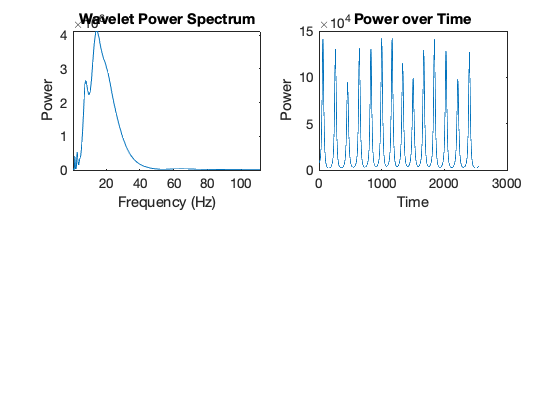

In [5]:
fb = cwtfilterbank( 'SignalLength', 2560, ...
                    'SamplingFrequency', DREAMER.ECG_SamplingRate);

sig = DREAMER.Data{1, 1}.ECG.stimuli{1, 1}(1:2560, 1)';
[cfs,frq] = wt(fb,sig);

t = (0:2559)/DREAMER.ECG_SamplingRate;

figure;
pcolor(t,frq,abs(cfs))
set(gca,'yscale','log');
shading interp;
axis tight;
title('Scalogram');
xlabel('Time (s)');
ylabel('Frequency (Hz)')

### 3.1 Convert ECG signal into CWT
The `helperMakeCWT` function computes the continuous wavelet transform (CWT) of an input ECG signal and returns the CWT as an RGB image. The function takes three input arguments:

- `fb`: a filter bank object obtained using the cwtfilterbank function.
- `normalizedSignal`: the input ECG signal, which has been z-score normalized using the helperNormalizeSignal function.
- `imgSize`: the desired size of the output image in pixels.

The function first computes the CWT of the input signal using the `abs(fb.wt(normalizedSignal))` function call. This returns a matrix of wavelet coefficients that represent the frequency and time information of the input signal.

Next, the function converts the wavelet coefficients to an RGB image using the `ind2rgb` function. The `im2uint8` function is used to convert the wavelet coefficients to unsigned 8-bit integers, and the `rescale` function is used to scale the values to the range [0,1]. The `jet` colormap is applied to the image to represent the wavelet coefficients using different colors.

Finally, the function resizes the RGB image to the desired size `imgSize` using the `imresize` function, and returns the resized image as `cwt`.

Overall, the function computes the continuous wavelet transform of an input ECG signal and returns it as an RGB image that represents the frequency and time information of the signal.

In [12]:
%%file helperFunctions/helperMakeCWT.m

function cwt = helperMakeCWT(fb, normalizedSignal, imgSize)
    % Compute the continuous wavelet transform of the normalized signal
    cfs = abs(fb.wt(normalizedSignal));

    % Convert the wavelet coefficients to an RGB image
    im = ind2rgb(im2uint8(rescale(cfs)),jet(128));
    
    % Resize the image to imgSize x imgSize
    cwt = imresize(im,[imgSize imgSize]);
end

Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/helperFunctions/helperMakeCWT.m'.


### 3.2 Putting it all togather

Following is helper function to pretty print progress bars

In [13]:
%%file progress_bar.m

function bar = progress_bar(progress, text)
    bar = [repmat('█', 1, floor(progress*20)), repmat('░', 1, 20 - floor(progress*20))];
    bar = sprintf('[%s] %s', bar, text);
end

Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/progress_bar.m'.


and a helper function to get the appropriate label for a signal chunk given its valence and arousal

In [14]:
%%file helperGetOutputLabel.m

function label = helperGetOutputLabel(valence, arousal)
    
    if valence > 2
        valence = "HV";
    else
        valence = "LV";
    end
    
    if arousal > 2
        arousal = "HA";
    else
        arousal = "LA";
    end

    label = valence + arousal;

end


Created file '/Users/abdullahmeda/Library/CloudStorage/OneDrive-Personal/BSc-Thesis/getOutputLabel.m'.


Putting all the pre-processing steps togather, this particular code block loops over 18 video sequences and 23 experimental subjects, filters the ECG signal for each subject, and iterates over the signal in 15-second chunks. It then extracts the current chunk of the signal, subtracts the baseline signal, normalizes the clean signal, computes the continuous wavelet transform of the normalized signal, and saves the resulting image to a directory with the appropriate label.

The progress of the loop is tracked and a progress bar is displayed using the `progress_bar` function. The progress bar is updated on each iteration of the outermost loop.

In [5]:
progress = 0; % initialize progress

for str = {'Morse', 'amor', 'bump'}
    wavelet = str{1};
    cfb = cwtfilterbank('SignalLength', CHUNK_SAMPLE_SIZE, ...
                        'SamplingFrequency', DREAMER.ECG_SamplingRate, ...
                        'Wavelet', wavelet);

    for i = 1:DREAMER.noOfVideoSequences    % 18 video sequences
    
        for j = 1:DREAMER.noOfSubjects      % 23 experimental subjects
    
            % Get the valence and arousal scores for the current video sequencecand subject
            valence = DREAMER.Data{j}.ScoreValence(i);
            arousal = DREAMER.Data{j}.ScoreArousal(i);
    
            % Get the output label (class) for the current signal
            label = helperGetOutputLabel(valence, arousal);
    
            for k = 1:2 % 2 ECG channels
    
                % Filter the ECG signal using a lowpass filter
                signal = helperApplyLowPassFilter(  SAMPLING_FREQ, ...
                                                    LOWPASS_CUTOFF_FREQ, ...
                                                    LOWPASS_CUTOFF_FREQ, ...
                                                    DREAMER.Data{1, j}.ECG.stimuli{i, 1}(:, k)' ...
                                                 );
    
                % Iterate over the signal in chunks of 15 seconds
                for m = CHUNK_SAMPLE_SIZE:CHUNK_SAMPLE_SIZE:size(signal, 2)
                    
                    % Extract the current chunk of the signal
                    signalChunk = signal(1, m-(CHUNK_SAMPLE_SIZE-1):m);
            
                    % Get the baseline signal for the current video sequence, subject, and ECG 
                    % channel and subtract it from the current chunk of the signal
                    baselineSig = helperComputeMeanBaselineSig(DREAMER, i, j, k, SAMPLING_FREQ, SIGNAL_CHUCK_SECS);
                    cleanSig = helperSubtractBaseline(baselineSig, signalChunk, SAMPLING_FREQ, SIGNAL_CHUCK_SECS);
    
                    % Z-Score Normalize the clean signal
                    normalizedSignal = helperNormalizeSignal(cleanSig);
    
                    % Compute the continuous wavelet transform of the normalized signal
                    cwt = helperMakeCWT(cfb, normalizedSignal, CWT_IMG_SIZE);
                    
                    % Define the directory and filename for saving the image and save it
                    imgLoc = fullfile(PARENT_DIR, "data", wavelet, label);
                    imFileName = sprintf("%d_%d_%d | %d-%d.jpg", j, i, k, m-(CHUNK_SAMPLE_SIZE-1), m);
                    imwrite(cwt,fullfile(imgLoc,imFileName));
    
                end
                
            end
        
        end

    end
    
    progress = i/DREAMER.noOfVideoSequences; % update progress
    
    % display progress bar
    text = sprintf('Progress: %d%%', round(progress*100));
    bar = progress_bar(progress, text); % call progress_bar function
    fprintf('\r%s', bar); % move cursor to beginning of line and print progress bar
    
end

     1

     2

     3

     4

     5

     6

     7

     8

     9

    10

    11

    12

    13

the MATLAB function has been cancelled
